In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from scipy.cluster.hierarchy import single

from AlignAIR.Utilities.step_utilities import DataConfigLibrary

sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (20,11)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.alpha'] = 1
mpl.rcParams['grid.linewidth'] = 1

C:\Users\tomas\Desktop\AlignAIR\AlignAIR_ENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
import logging
import yaml
import questionary
import tensorflow as tf
from AlignAIR.PostProcessing.Steps.allele_threshold_step import MaxLikelihoodPercentageThresholdApplicationStep, \
    ConfidenceMethodThresholdApplicationStep
from AlignAIR.PostProcessing.Steps.clean_up_steps import CleanAndArrangeStep
from AlignAIR.PostProcessing.Steps.correct_likelihood_for_genotype_step import GenotypeBasedLikelihoodAdjustmentStep
from AlignAIR.PostProcessing.Steps.finalization_and_packaging_steps import FinalizationStep
from AlignAIR.PostProcessing.Steps.germline_alignment_steps import AlleleAlignmentStep
from AlignAIR.PostProcessing.Steps.segmentation_correction_steps import SegmentCorrectionStep
from AlignAIR.PostProcessing.Steps.translate_to_imgt_step import TranslationStep
from AlignAIR.PredictObject.PredictObject import PredictObject
from AlignAIR.Preprocessing.Steps.batch_processing_steps import BatchProcessingStep
from AlignAIR.Preprocessing.Steps.dataconfig_steps import ConfigLoadStep
from AlignAIR.Preprocessing.Steps.file_steps import FileNameExtractionStep, FileSampleCounterStep
from AlignAIR.Preprocessing.Steps.model_loading_steps import ModelLoadingStep
from AlignAIR.Step.Step import Step

# Set TensorFlow logging level to ERROR
tf.get_logger().setLevel('ERROR')
class Args:
    """
       A class to convert dictionary entries to class attributes.
    """
    def __init__(self, **entries):
        self.__dict__.update(entries)


In [3]:
import argparse
"""
Here we load all the parameters needed for using the complete AlignAIR suite, including the post-processing and pre-processing steps.
This is usually done via Docker or CLI, thus we imitate the parameters one would pass in the command line and load all of them into an argparse namespace.
"""

args = argparse.Namespace(
    mode=None,
    config_file='',# this is for the YAML file mode and is not relevant here,
    model_checkpoint=r'C:\Users\tomas\Desktop\AlignAIRR\tests\AlignAIRR_S5F_OGRDB_V8_S5F_576_Balanced_V2', # check point of trained model weights
    save_path='/Users/tomas/Downloads/', # path for the saved results
    chain_type='heavy', # type of chain i.e heavy/light
    sequences=r'C:\Users\tomas\Desktop\AlignAIRR\tests\sample_HeavyChain_dataset.csv', # the target sequences, can be csv/tsv/FASTA file, csv and tsv must have a column called "sequecne"
    lambda_data_config='D', # if custom lambda dataconfig is required else leave as "D"
    kappa_data_config='D', # if custom kappa dataconfig is required else leave as "D"
    heavy_data_config='D', # if custom heavy chain dataconfig is required else leave as "D"
    max_input_size=576, # max input size, has to match the max_size of the trained model
    batch_size=8, # the maximum number of samples per batch processed by the model
    v_allele_threshold=0.1, # the threshold for v allele call likelihood consideration
    d_allele_threshold=0.1, # the threshold for d allele call likelihood consideration
    j_allele_threshold=0.1, # the threshold for j allele call likelihood consideration
    v_cap=3, # the maximum number of v allele calls the model will select based on the likelihood predicted and the threshold
    d_cap=3, # the maximum number of d allele calls the model will select based on the likelihood predicted and the threshold
    j_cap=3, # the maximum number of j allele calls the model will select based on the likelihood predicted and the threshold
    translate_to_asc=True, # in case ASC were derived for the DataConfig, this will transalte the ASC's to IMGT allele names
    fix_orientation=True, # this flag controls wheter the preprocessing should check if there are reversed sequences and orient them properly
    custom_orientation_pipeline_path=None ,# in case you have a custom model you will need to create a custom orientation pipeline, and specify the path here
    custom_genotype=None,
    finetuned_model_params_yaml=None
)

In [4]:
MODEL_CHECKPOINT = r'C:/Users/tomas/Desktop/AlignAIR/tests/AlignAIRR_S5F_OGRDB_V8_S5F_576_Balanced_V2'


# Loading The Model

In [5]:
from AlignAIR.Data import HeavyChainDataset
from GenAIRR.data import builtin_heavy_chain_data_config

dataconfig_insatnce = builtin_heavy_chain_data_config() # make sure the dataconfig you are using matches your dataset (the alleles in your dataset should share the same reference for the V,D and J alleles as the dataconfig object)
heavy_chain_dataset_path = r'C:/Users/tomas/Desktop/AlignAIR/tests/sample_HeavyChain_dataset.csv'
train_dataset = HeavyChainDataset(data_path=heavy_chain_dataset_path,
                                  dataconfig=dataconfig_insatnce, use_streaming=True,
                                  max_sequence_length=576)

In [6]:
from AlignAIR.Models.HeavyChain import HeavyChainAlignAIRR
from AlignAIR.Trainers import Trainer

dataconfig_= builtin_heavy_chain_data_config()
max_sequence_length = 576
v_allele_count = len([i for j in dataconfig_.v_alleles for i in dataconfig_.v_alleles[j]])
d_allele_count = len([i for j in dataconfig_.d_alleles for i in dataconfig_.d_alleles[j]])+1
j_allele_count = len([i for j in dataconfig_.j_alleles for i in dataconfig_.j_alleles[j]])

trainer = Trainer(
    model=HeavyChainAlignAIRR(
        max_seq_length=max_sequence_length,
        v_allele_count=v_allele_count,
        d_allele_count=d_allele_count,
        j_allele_count=j_allele_count
    ),
    epochs=1,
    steps_per_epoch=512,
    batch_size=8,
    verbose=1,
    classification_metric=[tf.keras.metrics.AUC(), tf.keras.metrics.AUC(), tf.keras.metrics.AUC()],
    regression_metric=tf.keras.losses.binary_crossentropy,
    pretrained_path=MODEL_CHECKPOINT,
    max_seq_length=max_sequence_length
)


tanh
Model built with input shape: (576,1)
Model weights loaded from C:/Users/tomas/Desktop/AlignAIR/tests/AlignAIRR_S5F_OGRDB_V8_S5F_576_Balanced_V2.


In [7]:
from AlignAIR.PostProcessing.Steps.allele_threshold_step import MaxLikelihoodPercentageThresholdApplicationStep, \
    ConfidenceMethodThresholdApplicationStep
from AlignAIR.PostProcessing.Steps.clean_up_steps import CleanAndArrangeStep
from AlignAIR.PostProcessing.Steps.finalization_and_packaging_steps import FinalizationStep
from AlignAIR.PostProcessing.Steps.germline_alignment_steps import AlleleAlignmentStep
from AlignAIR.PostProcessing.Steps.segmentation_correction_steps import SegmentCorrectionStep
from AlignAIR.PostProcessing.Steps.translate_to_imgt_step import TranslationStep
from AlignAIR.PredictObject.PredictObject import PredictObject
from AlignAIR.Preprocessing.Steps.batch_processing_steps import BatchProcessingStep
from AlignAIR.Preprocessing.Steps.dataconfig_steps import ConfigLoadStep
from AlignAIR.Preprocessing.Steps.file_steps import FileNameExtractionStep, FileSampleCounterStep
from AlignAIR.Preprocessing.Steps.model_loading_steps import ModelLoadingStep
import logging
from AlignAIR.Step.Step import Step
# create a logger to log the process
logger = logging.getLogger('PipelineLogger')
Step.set_logger(logger)

# set up t he predict objecet, here all the predicted information and processed results will be saved
predict_object = PredictObject(args, logger=logger)


In [8]:
from AlignAIR.Data.PredictionDataset import PredictionDataset
from AlignAIR.Utilities.step_utilities import DataConfigLibrary
from IPython.display import clear_output
class SingleInstancePredictor:
    def __init__(self,model):
        self.model = model

        self.steps = [
            CleanAndArrangeStep("Clean Up Raw Prediction"),
            SegmentCorrectionStep("Correct Segmentations"),
            MaxLikelihoodPercentageThresholdApplicationStep("Apply Max Likelihood Threshold to Distill Assignments"),
            AlleleAlignmentStep("Align Predicted Segments with Germline"),
            TranslationStep("Translate ASC's to IMGT Alleles"),
        ]

        self.finalization_step =  FinalizationStep("Finalize Post Processing and Save Csv")


        self.encoder = PredictionDataset(max_sequence_length=576)

    def _format_output(self,predict_object):
        cleaned_data = predict_object.processed_predictions
        germline_alignments = predict_object.germline_alignments

        sequences = predict_object.sequences

        # Compile results into a DataFrame
        final_csv = pd.DataFrame({
            'sequence': sequences,
            'v_call': [','.join(i) for i in predict_object.selected_allele_calls['v']],
            'j_call': [','.join(i) for i in predict_object.selected_allele_calls['j']],
            'v_sequence_start': [i['start_in_seq'] for i in predict_object.germline_alignments['v']],
            'v_sequence_end': [i['end_in_seq'] for i in predict_object.germline_alignments['v']],
            'j_sequence_start': [i['start_in_seq'] for i in predict_object.germline_alignments['j']],
            'j_sequence_end': [i['end_in_seq'] for i in predict_object.germline_alignments['j']],
            'v_germline_start': [max(0, i['start_in_ref']) for i in predict_object.germline_alignments['v']],
            'v_germline_end': [i['end_in_ref'] for i in predict_object.germline_alignments['v']],
            'j_germline_start': [max(0, i['start_in_ref']) for i in predict_object.germline_alignments['j']],
            'j_germline_end': [i['end_in_ref'] for i in predict_object.germline_alignments['j']],
            'v_likelihoods': predict_object.likelihoods_of_selected_alleles['v'],
            'j_likelihoods': predict_object.likelihoods_of_selected_alleles['j'],
            'mutation_rate': predict_object.processed_predictions['mutation_rate'],
            'ar_indels': predict_object.processed_predictions['indel_count'],
            'ar_productive': predict_object.processed_predictions['productive'],
        })

        if predict_object.data_config_library.mounted == 'heavy':
            final_csv['d_sequence_start'] = [i['start_in_seq'] for i in predict_object.germline_alignments['d']]
            final_csv['d_sequence_end'] = [i['end_in_seq'] for i in predict_object.germline_alignments['d']]
            final_csv['d_germline_start'] = [abs(i['start_in_ref']) for i in predict_object.germline_alignments['d']]
            final_csv['d_germline_end'] = [i['end_in_ref'] for i in predict_object.germline_alignments['d']]
            final_csv['d_call'] = [','.join(i) for i in predict_object.selected_allele_calls['d']]
            final_csv['d_likelihoods'] = predict_object.likelihoods_of_selected_alleles['d']
            final_csv['type'] = 'heavy'
        else:
            final_csv['type'] = ['kappa' if i == 1 else 'lambda' for i in predict_object.processed_predictions['type_'].astype(int).squeeze()]

        return final_csv

    def predict(self,sequence):
        encoded_seqs = []
        if type(sequence) == str:
            encoded = self.encoder.encode_and_equal_pad_sequence(sequence)
            encoded['tokenized_sequence'] = np.expand_dims(encoded['tokenized_sequence'], axis=0)
            prediction =  self.model.predict(encoded)
            predict_object = PredictObject(args, logger=logger)
            predict_object.data_config_library = DataConfigLibrary(*['D','D','D'])
            predict_object.data_config_library.mount_type('heavy')
            predict_object.sequences = [sequence]
            predict_object.raw_predictions = [prediction]


            for step in self.steps:
                predict_object = step.execute(predict_object)

            clear_output(True)
            return self._format_output(predict_object)
        else:
            encoded_seqs = [self.encoder.encode_and_equal_pad_sequence(seq) for seq in sequence]
            # merge dictionaries
            encoded_seqs = {'tokenized_sequence':[i['tokenized_sequence'] for i in encoded_seqs] }
            encoded_seqs['tokenized_sequence'] = np.array(encoded_seqs['tokenized_sequence'])
            prediction =  self.model.predict(encoded_seqs)
            predict_object = PredictObject(args, logger=logger)
            predict_object.data_config_library = DataConfigLibrary(*['D','D','D'])
            predict_object.data_config_library.mount_type('heavy')
            predict_object.sequences = sequence
            predict_object.raw_predictions = [prediction]


            for step in self.steps:
                predict_object = step.execute(predict_object)
            clear_output(True)
            return self._format_output(predict_object)





In [9]:
predictor = SingleInstancePredictor(trainer.model)
seq = 'NCCGCCATATTCCAGACCAGGGACTGGAGTGGGTGGCGGTTATCTCTTAGGACGGAAGTAATTCATACGGCACAGACTCCGTGAAGGGNCCATTTACCCTCTCCAGAGACCATTCCAAGAACACGCTCNGCCCACAGATGAACANCCTGAGAGGTGGGGACACGGCTGTGTCCTCTCGGGCGAGAGGATTTTTATGCCGACAGCACTTTTGATTTCTGGGGCCAAGGGACAATGGTCACCGTCTCCTCAG'
prediction = predictor.predict([seq,seq])

1/1 [==============================] - 4s 4s/step


Matching D Germlines: 100%|██████████| 2/2 [00:00<?, ?it/s]


In [10]:
prediction

,sequence,v_call,j_call,v_sequence_start,v_sequence_end,j_sequence_start,j_sequence_end,v_germline_start,v_germline_end,j_germline_start,...,mutation_rate,ar_indels,ar_productive,d_sequence_start,d_sequence_end,d_germline_start,d_germline_end,d_call,d_likelihoods,type
0,NCCGCCATATTCCAGACCAGGGACTGGAGTGGGTGGCGGTTATCTC...,"IGHVF10-G37*04,IGHVF10-G37*05,IGHVF10-G37*03",IGHJ3*02,0,186,204,250,109,295,4,...,0.173604,0.0,False,187,196,8,17,"IGHD3-10*03,IGHD3-10*01,IGHD3-22*01","[0.36991706, 0.3499555, 0.24809411]",heavy
1,NCCGCCATATTCCAGACCAGGGACTGGAGTGGGTGGCGGTTATCTC...,"IGHVF10-G37*04,IGHVF10-G37*05,IGHVF10-G37*03",IGHJ3*02,0,186,204,250,109,295,4,...,0.173604,0.0,False,187,196,8,17,"IGHD3-10*03,IGHD3-10*01,IGHD3-22*01","[0.36991706, 0.3499555, 0.24809411]",heavy


# Stress Test of Noise Added To Start of Sequence / End of Sequence

In [11]:
from GenAIRR.pipeline import AugmentationPipeline
from GenAIRR.steps import AugmentationStep
from GenAIRR.dataconfig import DataConfig
from GenAIRR.data import builtin_heavy_chain_data_config, builtin_kappa_chain_data_config
from GenAIRR.pipeline import CHAIN_TYPE_BCR_HEAVY

# Initialize a built-in DataConfig
data_config_builtin = builtin_heavy_chain_data_config()

# Set up the data configuration and chain type for the simulations
AugmentationStep.set_dataconfig(data_config_builtin,chain_type=CHAIN_TYPE_BCR_HEAVY)

In [12]:
from GenAIRR.pipeline import AugmentationPipeline
from GenAIRR.steps import SimulateSequence, FixVPositionAfterTrimmingIndexAmbiguity
from GenAIRR.mutation import S5F
from GenAIRR.data import builtin_heavy_chain_data_config
from GenAIRR.steps.StepBase import AugmentationStep
from GenAIRR.pipeline import CHAIN_TYPE_BCR_HEAVY
from GenAIRR.steps import SimulateSequence,FixVPositionAfterTrimmingIndexAmbiguity,FixDPositionAfterTrimmingIndexAmbiguity,FixJPositionAfterTrimmingIndexAmbiguity
from GenAIRR.steps import CorrectForVEndCut,CorrectForDTrims,CorruptSequenceBeginning,InsertNs,InsertIndels,ShortDValidation,DistillMutationRate
from GenAIRR.mutation import S5F

pipeline = AugmentationPipeline([
    SimulateSequence(mutation_model = S5F(min_mutation_rate=0.003,max_mutation_rate=0.25),productive = True),
    FixVPositionAfterTrimmingIndexAmbiguity(),
    FixDPositionAfterTrimmingIndexAmbiguity(),
    FixJPositionAfterTrimmingIndexAmbiguity(),
    CorrectForVEndCut(),
    CorrectForDTrims(),
    # CorruptSequenceBeginning(corruption_probability = 0.7,corrupt_events_proba = [0.4,0.4,0.2],max_sequence_length = 576,nucleotide_add_coefficient = 210,
    #                          nucleotide_remove_coefficient = 310,nucleotide_add_after_remove_coefficient = 50,random_sequence_add_proba = 1,
    #                          single_base_stream_proba = 0,duplicate_leading_proba = 0,random_allele_proba = 0),
    #InsertNs(n_ratio = 0.02,proba = 0.5),
    ShortDValidation(short_d_length= 5),
    # InsertIndels(indel_probability = 0.5,max_indels = 5,insertion_proba=0.5,deletion_proba=0.5),
    #
    DistillMutationRate()
    ])

In [13]:
simulation =  pipeline.execute()

In [14]:
prediction.columns

Index(['sequence', 'v_call', 'j_call', 'v_sequence_start', 'v_sequence_end',
       'j_sequence_start', 'j_sequence_end', 'v_germline_start',
       'v_germline_end', 'j_germline_start', 'j_germline_end', 'v_likelihoods',
       'j_likelihoods', 'mutation_rate', 'ar_indels', 'ar_productive',
       'd_sequence_start', 'd_sequence_end', 'd_germline_start',
       'd_germline_end', 'd_call', 'd_likelihoods', 'type'],
      dtype='object')

## Shift Tests

In [17]:
source_sample = pipeline.execute()
source_prediction = predictor.predict(source_sample['sequence'])
source_prediction = source_prediction.iloc[0]
clear_output()

In [18]:
noise_levels = list(range(1,11))+[15,20,25,30,35,40,45,50]
noise_orientations  = ['start','end','both']
n_samples_per_noise = 10

simulated_samples = []
noise_ = []
orientation_ = []
for noise_level in noise_levels:
    for noise_orientation in noise_orientations:
        for _ in range(n_samples_per_noise):
            sample = source_sample.sequence
            random_dna = ''.join(np.random.choice(['A','C','G','T'],noise_level))
            random_dna2 = ''.join(np.random.choice(['A','C','G','T'],noise_level))

            if noise_orientation == 'start':
                sample = random_dna + sample
            elif noise_orientation == 'end':
                sample = sample + random_dna
            else:
                sample = random_dna + sample + random_dna2
            simulated_samples.append(sample)
            noise_.append(noise_level)
            orientation_.append(noise_orientation)


In [19]:
orientation_ = np.array(orientation_)
noise_ = np.array(noise_)

In [20]:
predictions = predictor.predict(simulated_samples)

17/17 [==============================] - 9s 552ms/step


Matching D Germlines: 100%|██████████| 540/540 [00:00<00:00, 34481.60it/s]


In [21]:
pdf = predictions

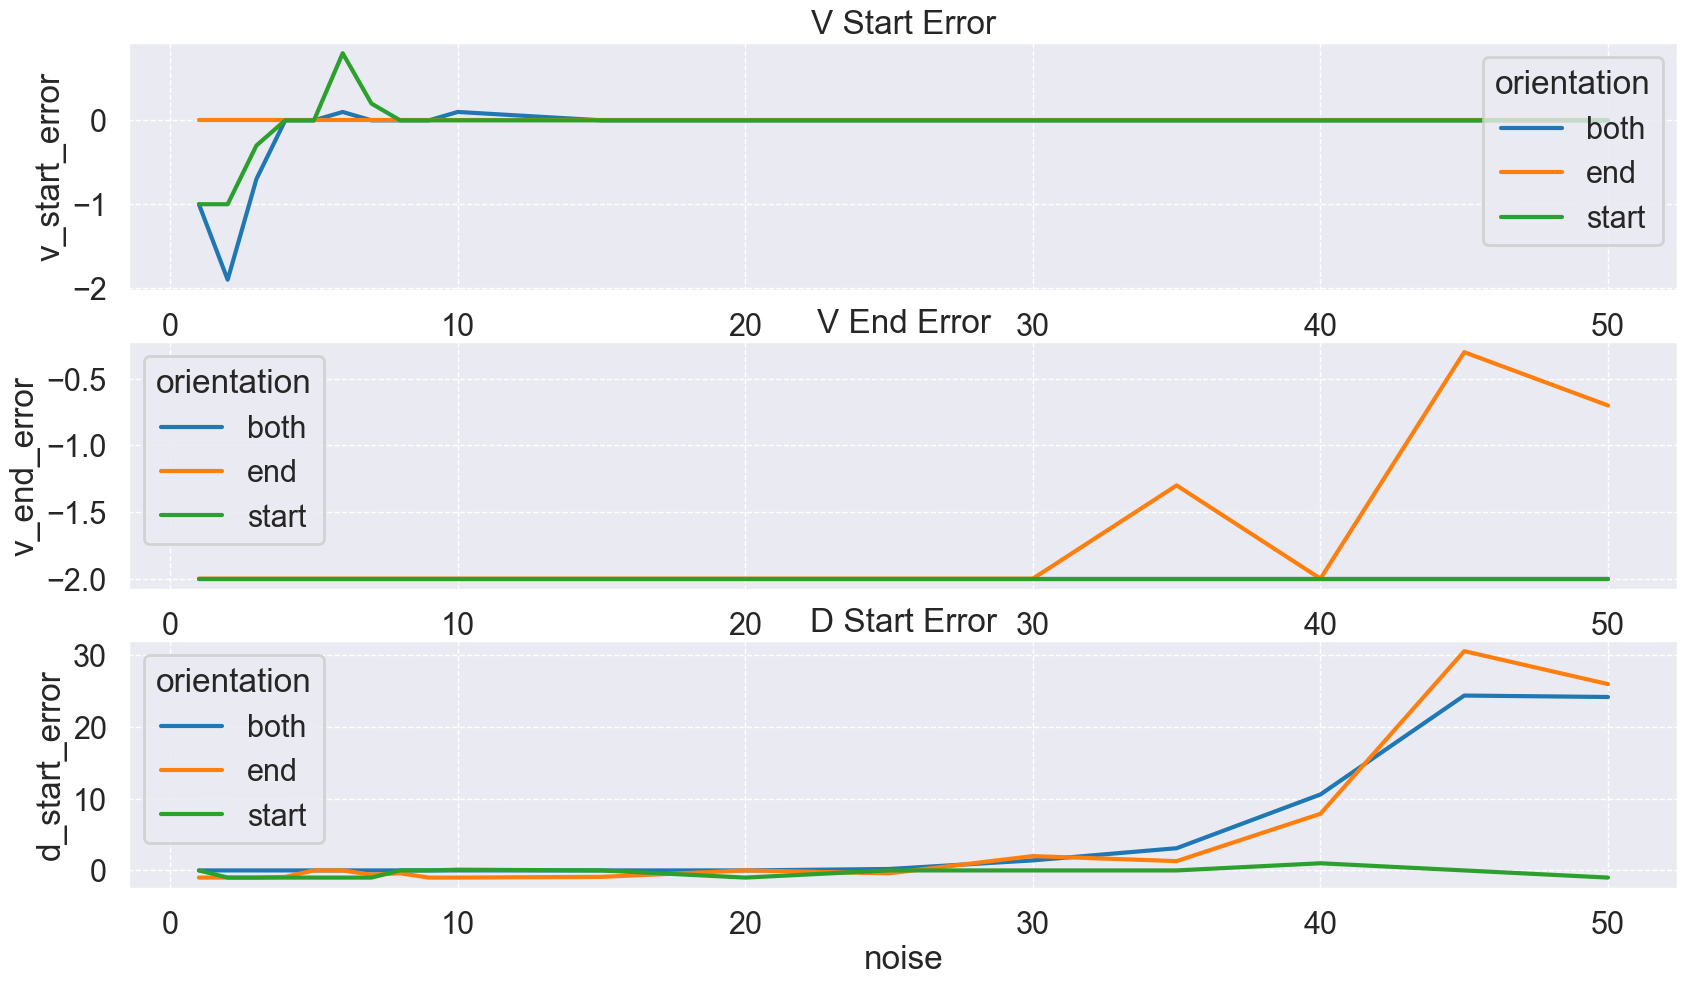

In [22]:
v_start_error = pdf['v_sequence_start'] - source_sample.v_sequence_start
v_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
v_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

v_end_error = pdf['v_sequence_end'] - source_sample.v_sequence_end
v_end_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
v_end_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']


d_start_error = pdf['d_sequence_start'] - source_sample.d_sequence_start
d_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
d_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

d_end_error = pdf['d_sequence_end'] - source_sample.d_sequence_end
d_end_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
d_end_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

j_start_error = pdf['j_sequence_start'] - source_sample.j_sequence_start
j_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
j_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

# group by noise_
error_df = pd.DataFrame({
    'v_start_error':v_start_error,
    'v_end_error':v_end_error,
    'd_start_error':d_start_error,
    'd_end_error':d_end_error,
    'j_start_error':j_start_error,

    'noise':noise_,'orientation':orientation_,


                         }).groupby(['noise','orientation']).mean()

# plot lineplot noise level vs error per orientation
plt.subplot(3,1,1)
sns.lineplot(data=error_df,x='noise',y='v_start_error',hue='orientation')
plt.title('V Start Error')
plt.subplot(3,1,2)
sns.lineplot(data=error_df,x='noise',y='v_end_error',hue='orientation')
plt.title('V End Error')
plt.subplot(3,1,3)
sns.lineplot(data=error_df,x='noise',y='d_start_error',hue='orientation')
plt.title('D Start Error')
plt.show()

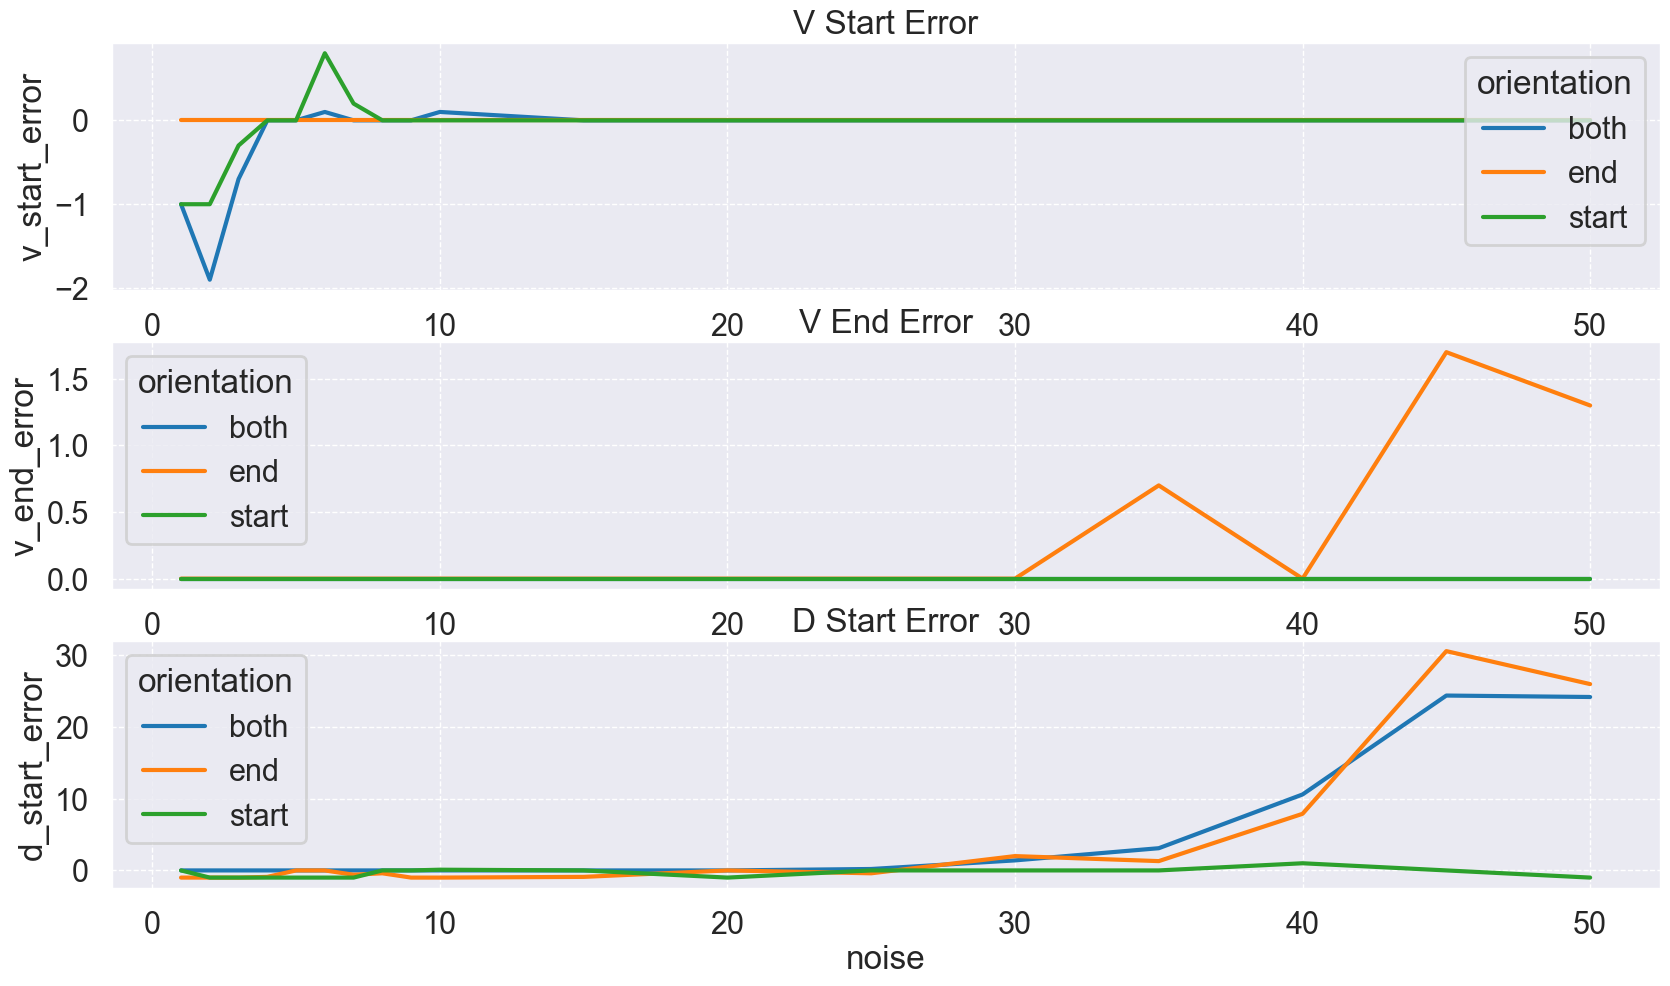

In [23]:
v_start_error = pdf['v_sequence_start'] - source_prediction.v_sequence_start
v_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
v_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

v_end_error = pdf['v_sequence_end'] - source_prediction.v_sequence_end
v_end_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
v_end_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']


d_start_error = pdf['d_sequence_start'] - source_prediction.d_sequence_start
d_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
d_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

d_end_error = pdf['d_sequence_end'] - source_prediction.d_sequence_end
d_end_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
d_end_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

j_start_error = pdf['j_sequence_start'] - source_prediction.j_sequence_start
j_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
j_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

# group by noise_
error_df = pd.DataFrame({
    'v_start_error':v_start_error,
    'v_end_error':v_end_error,
    'd_start_error':d_start_error,
    'd_end_error':d_end_error,
    'j_start_error':j_start_error,

    'noise':noise_,'orientation':orientation_,


                         }).groupby(['noise','orientation']).mean()

# plot lineplot noise level vs error per orientation
plt.subplot(3,1,1)
sns.lineplot(data=error_df,x='noise',y='v_start_error',hue='orientation')
plt.title('V Start Error')
plt.subplot(3,1,2)
sns.lineplot(data=error_df,x='noise',y='v_end_error',hue='orientation')
plt.title('V End Error')
plt.subplot(3,1,3)
sns.lineplot(data=error_df,x='noise',y='d_start_error',hue='orientation')
plt.title('D Start Error')
plt.show()

In [160]:
source_sample.v_sequence_end

296

## Adversarial Attack Model and Tests

In [48]:
import tensorflow as tf
from tensorflow.keras import Model
import numpy as np
from flask import Flask, render_template_string, jsonify
import time
import threading
from flask import Flask, render_template_string, jsonify, request
import time
import threading

class WebProgressBar:
    def __init__(self, total, title="Progress Tracker"):
        self.total = total
        self.current = 0
        self.start_time = time.time()
        self.lock = threading.Lock()
        self.title = title
        self.shutdown_flag = False

        # Start the Flask app in a separate thread
        self.app = Flask(__name__)
        self._setup_routes()
        self.server_thread = threading.Thread(target=self._run_server, daemon=True)
        self.server_thread.start()

    def _setup_routes(self):
        @self.app.route("/")
        def index():
            return render_template_string(self._html_template())

        @self.app.route("/progress")
        def progress():
            with self.lock:
                elapsed = time.time() - self.start_time
                rate = self.current / elapsed if elapsed > 0 else 0
                remaining = (self.total - self.current) / rate if rate > 0 else 0

                return jsonify({
                    "current": self.current,
                    "total": self.total,
                    "percentage": round((self.current / self.total) * 100, 2),
                    "elapsed_time": round(elapsed, 2),
                    "remaining_time": round(remaining, 2) if remaining > 0 else "N/A",
                    "iterations_per_second": round(rate, 2),
                    "finished": self.shutdown_flag
                })

        @self.app.route("/shutdown", methods=["POST"])
        def shutdown():
            self.shutdown_flag = True
            shutdown_func = request.environ.get("werkzeug.server.shutdown")
            if shutdown_func:
                shutdown_func()
            return "Server shutting down..."

    def _run_server(self):
        self.app.run(debug=False, use_reloader=False, port=5000)

    def update(self, n=1):
        with self.lock:
            self.current += n

    def set(self, value):
        with self.lock:
            self.current = value

    def finish(self):
        with self.lock:
            self.current = self.total
        self._shutdown_server()

    def _shutdown_server(self):
        try:
            import requests
            requests.post("http://127.0.0.1:5000/shutdown")  # Send shutdown request
        except:
            pass  # Ignore errors (e.g., server already stopped)

    def _html_template(self):
        return """
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>{{ title }}</title>
            <script>
                function updateProgress() {
                    fetch('/progress')
                        .then(response => response.json())
                        .then(data => {
                            document.getElementById('progress-bar').style.width = data.percentage + "%";
                            document.getElementById('progress-text').innerText = data.current + " / " + data.total + " (" + data.percentage + "%)";
                            document.getElementById('elapsed').innerText = "Elapsed Time: " + data.elapsed_time + "s";
                            document.getElementById('remaining').innerText = "Estimated Remaining: " + data.remaining_time + "s";
                            document.getElementById('rate').innerText = "Speed: " + data.iterations_per_second + " it/s";

                            if (data.finished) {
                                document.getElementById('shutdown-message').innerText = "Progress Completed. Server is shutting down...";
                                setTimeout(() => window.location.reload(), 3000);
                            }
                        });
                }
                setInterval(updateProgress, 1000);
            </script>
            <style>
                body { font-family: Arial, sans-serif; text-align: center; padding: 20px; }
                .progress-container { width: 80%; background: #eee; border-radius: 10px; overflow: hidden; margin: auto; margin-top: 20px; }
                .progress-bar { height: 30px; background: #4caf50; text-align: center; color: white; line-height: 30px; width: 0%; transition: width 0.5s; }
            </style>
        </head>
        <body>
            <h2>{{ title }}</h2>
            <div class="progress-container">
                <div class="progress-bar" id="progress-bar">0%</div>
            </div>
            <p id="progress-text">0 / 0 (0%)</p>
            <p id="elapsed">Elapsed Time: 0s</p>
            <p id="remaining">Estimated Remaining: N/A</p>
            <p id="rate">Speed: 0 it/s</p>
            <p id="shutdown-message" style="color: red; font-weight: bold;"></p>
        </body>
        </html>
        """
import time




RANDOM_DIM = 32
DNA_BASES = ['A', 'C', 'G', 'T','N','_']
INTEGER_TO_DNA = {i: DNA_BASES[i] for i in range(len(DNA_BASES))}

class PrefixGenerator(tf.keras.Model):
    def __init__(self, max_prefix_len, vocab_size, hidden_dim=64):
        super().__init__()
        self.max_prefix_len = max_prefix_len
        self.vocab_size = vocab_size

        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(self.max_prefix_len * self.vocab_size)

    def call(self, z):
        """
        z: random noise or embedding [batch_size, random_dim]
        Returns: logits shape [batch_size, max_prefix_len, vocab_size]
        """
        h = self.dense1(z)
        h = self.dense2(h)
        # reshape to [batch_size, max_prefix_len, vocab_size]
        h = tf.reshape(h, [-1, self.max_prefix_len, self.vocab_size])
        return h


import tensorflow as tf

class SimpleTransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),   # expansion
            tf.keras.layers.Dense(embed_dim)                    # project back
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False):
        # Self-attention
        attn_output = self.mha(query=x, value=x, key=x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # residual + norm

        # Feed-forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class AlignAIRAdversarial:
    def __init__(
        self,
        pipeline,
        predictor,
        random_dim=32,
        max_prefix_len=150,
        vocab_size=len(DNA_BASES),
        hidden_dim=64,
        learning_rate=1e-3
    ):
        """
        Encapsulates the entire adversarial-like logic for training a
        prefix generator to confuse an AIRR alignment predictor.

        Args:
            pipeline:   An object with an `execute()` method that returns a source_sample.
            predictor:  An object with a `predict(list_of_sequences)` method returning alignments.
            random_dim: Dimensionality of the random noise vector.
            max_prefix_len: Maximum length of the prefix to generate.
            vocab_size: Size of the DNA vocabulary (A, C, G, T, N, _).
            hidden_dim: Number of hidden units in the generator’s dense layer.
            learning_rate: Learning rate for the optimizer.
        """
        self.pipeline = pipeline
        self.predictor = predictor

        self.random_dim = random_dim
        self.max_prefix_len = max_prefix_len
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate

        # Initialize the generator
        self.generator = self._build_attention_generator()

        # Define the optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def _build_generator(self):
        """
        Builds and returns the prefix generator (a small MLP that outputs
        logits for each token in the prefix).
        """
        # You can define the PrefixGenerator as an inner class or simply
        # define and return a Keras Model here.
        class PrefixGenerator(tf.keras.Model):
            def __init__(self, max_prefix_len, vocab_size, hidden_dim):
                super().__init__()
                self.max_prefix_len = max_prefix_len
                self.vocab_size = vocab_size
                self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
                self.dense2 = tf.keras.layers.Dense(max_prefix_len * vocab_size)

            def call(self, z):
                """
                z: [batch_size, random_dim]
                Returns: [batch_size, max_prefix_len, vocab_size] (logits)
                """
                h = self.dense1(z)
                h = self.dense2(h)
                # reshape to [batch_size, max_prefix_len, vocab_size]
                h = tf.reshape(h, [-1, self.max_prefix_len, self.vocab_size])
                return h

        return PrefixGenerator(self.max_prefix_len, self.vocab_size, self.hidden_dim)

    def _build_attention_generator(self):
        class TransformerPrefixGenerator(tf.keras.Model):
            def __init__(self, max_prefix_len, vocab_size, hidden_dim=64, num_heads=4, num_layers=2):
                super().__init__()
                self.max_prefix_len = max_prefix_len
                self.vocab_size = vocab_size

                self.input_projection = tf.keras.layers.Dense(hidden_dim)

                # Stack multiple encoder layers
                self.transformer_layers = [
                    SimpleTransformerEncoder(
                        embed_dim=hidden_dim,
                        num_heads=num_heads,
                        ff_dim=hidden_dim*4,
                        rate=0.1
                    ) for _ in range(num_layers)
                ]

                self.output_layer = tf.keras.layers.Dense(vocab_size)

            def call(self, z, training=None):
                """
                z: [batch_size, random_dim] (some noise vector)
                We project it to [batch_size, max_prefix_len, hidden_dim]
                so that we have a 'token' representation at each prefix position.
                """
                batch_size = tf.shape(z)[0]

                # For simplicity, tile the random vector across the prefix length
                # so each position sees the same initial embedding.
                # Or you can design something else:
                x = self.input_projection(z)  # shape (batch_size, hidden_dim)
                x = tf.expand_dims(x, axis=1) # shape (batch_size, 1, hidden_dim)
                x = tf.tile(x, [1, self.max_prefix_len, 1])  # shape (batch_size, max_prefix_len, hidden_dim)

                # Pass through each transformer layer
                for layer in self.transformer_layers:
                    x = layer(x, training=training)

                # Map hidden states to vocab-size logits
                logits = self.output_layer(x) # shape: [batch_size, max_prefix_len, vocab_size]
                return logits


        return TransformerPrefixGenerator(self.max_prefix_len, self.vocab_size, self.hidden_dim)

    @staticmethod
    def _translate_to_dna(integer_sequence):
        """
        Converts a sequence of integer indices into a DNA string, stopping at '_' if encountered.
        """
        seq = []
        for i in integer_sequence:
            base = INTEGER_TO_DNA.get(i, '_')  # default to '_' if out of range
            if base == '_':
                break
            seq.append(base)
        return ''.join(seq)

    @staticmethod
    def _sample_prefix(logits):
        """
        Discrete sampling using tf.random.categorical.

        Args:
          logits: [batch_size, max_len, vocab_size]
        Returns:
          prefix_tokens: [batch_size, max_len]
          sum_log_probs: [batch_size] (sum of log probs of chosen tokens)
        """
        batch_size = tf.shape(logits)[0]
        max_len = tf.shape(logits)[1]

        # 1) Flatten so we can sample for each position
        flat_logits = tf.reshape(logits, [batch_size * max_len, -1])  # shape: (batch_size*max_len, vocab_size)

        # 2) Sample exactly one token per position
        distribution = tf.random.categorical(flat_logits, num_samples=1)  # shape: (batch_size*max_len, 1)
        distribution = tf.cast(distribution, tf.int32)

        # Reshape to (batch_size, max_len)
        distribution = tf.reshape(distribution, [batch_size, max_len])

        # 3) Compute log_probs for each chosen token
        log_probs_all = tf.nn.log_softmax(logits, axis=-1)  # shape (batch_size, max_len, vocab_size)

        # Build the gather indices: shape (batch_size, max_len, 3)
        batch_indices = tf.range(batch_size, dtype=tf.int32)[:, tf.newaxis]  # (batch_size, 1)
        batch_indices = tf.tile(batch_indices, [1, max_len])                 # (batch_size, max_len)

        pos_indices = tf.range(max_len, dtype=tf.int32)[tf.newaxis, :]       # (1, max_len)
        pos_indices = tf.tile(pos_indices, [batch_size, 1])                  # (batch_size, max_len)

        # distribution is (batch_size, max_len)
        indices = tf.stack([batch_indices, pos_indices, distribution], axis=-1)  # (batch_size, max_len, 3)

        chosen_log_probs = tf.gather_nd(log_probs_all, indices)  # shape (batch_size, max_len)
        sum_log_probs = tf.reduce_sum(chosen_log_probs, axis=1)   # shape (batch_size,)

        return distribution, sum_log_probs

    def train_step(self, source_sample, batch_size=32):
        """
        Runs one REINFORCE-style training step.

        Args:
            source_sample: A sample object containing the reference sequence and
                           correct alignment positions, e.g. `source_sample.sequence`
                           and `source_sample.*_sequence_start/end`.
            batch_size:    How many sequences to generate per step.

        Returns:
            loss:         Scalar loss.
            mean_reward:  Mean reward in the batch.
        """
        # 1) Sample random noise
        z = tf.random.normal([batch_size, self.random_dim])

        with tf.GradientTape() as tape:
            # 2) Get logits from generator
            logits = self.generator(z)

            # 3) Sample discrete prefix
            prefix_tokens, log_probs = self._sample_prefix(logits)

            # 4) Convert prefix tokens to numpy (in eager mode this works)
            prefix_tokens_np = prefix_tokens.numpy()

            # Build sequences for predictor
            batch_sequences = []
            prefixes = []
            for i in range(batch_size):
                prefix_str = self._translate_to_dna(prefix_tokens_np[i])
                prefixes.append(prefix_str)
                full_seq = prefix_str + source_sample.sequence
                if len(full_seq) > 576:
                    diff = 576-len(full_seq)
                    full_seq = full_seq[diff+1:]
                batch_sequences.append(full_seq)
                print(full_seq,len(full_seq))

            # 5) Use your predictor to get alignment predictions
            #    (predictor should return a DataFrame or dict with alignment positions)
            predicted = self.predictor.predict(batch_sequences)
            prefix_length = np.array([len(pfx) for pfx in prefixes])

            # 6) Compute the reward (here, used as an "error" measure, so the smaller the better)
            total_error = (
                (predicted['v_sequence_start'] - source_sample.v_sequence_start - prefix_length)**2 +
                (predicted['v_sequence_end']   - source_sample.v_sequence_end   - prefix_length)**2 +
                (predicted['d_sequence_start'] - source_sample.d_sequence_start - prefix_length)**2 +
                (predicted['d_sequence_end']   - source_sample.d_sequence_end   - prefix_length)**2 +
                (predicted['j_sequence_start'] - source_sample.j_sequence_start - prefix_length)**2
            )

            rewards = tf.constant(total_error.to_numpy(), dtype=tf.float32)

            # 7) REINFORCE loss = - E[ reward * log_prob ]
            loss = -tf.reduce_mean(rewards * log_probs)

        # 8) Apply gradients
        grads = tape.gradient(loss, self.generator.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return loss, tf.reduce_mean(rewards)

    def train(self, steps=1000, batch_size=32):
        """
        Runs the main training loop for a specified number of steps.

        Args:
            steps:      Number of training iterations.
            batch_size: Number of sequences to generate and update on each step.
        """
        progress = WebProgressBar(steps, title="Adversarial Training")
        mean_rewards = []
        for step in range(steps):
            # Obtain a new source_sample from your pipeline
            source_sample = self.pipeline.execute()

            loss_val, mean_reward = self.train_step(source_sample, batch_size=batch_size)

            if step % 10 == 0:
                clear_output(wait=True)
                print(f"Step {step} | Loss: {loss_val.numpy():.3f} | MeanReward: {mean_reward.numpy():.3f}")

            mean_rewards.append(mean_reward.numpy())
            progress.update(1)
        progress.finish()

        return mean_rewards

In [49]:
adversarial_model = AlignAIRAdversarial(pipeline,predictor)

adversarial_model.train()

ValueError: index can't contain negative values

In [50]:
z = tf.random.normal([6000, 32])

logits = adversarial_model.generator(z)
prefix_tokens, log_probs = adversarial_model._sample_prefix(logits)
prefix_tokens_np = prefix_tokens.numpy()  # This works in eager mode
#full_seq = prefix_str + source_sequence.sequence


KeyboardInterrupt: 

In [23]:
prefixes = []
prefixed_sequences = []
errors = []
source_v_start = []
source_v_end = []
source_d_start = []
source_d_end = []
source_j_start = []
source_j_end = []

for prefix_tokens in prefix_tokens_np:
    source_sample = pipeline.execute()
    prefix_str = adversarial_model._translate_to_dna(prefix_tokens)
    prefixed_sequence = prefix_str + source_sample.sequence
    prefixes.append(prefix_str)
    prefixed_sequences.append(prefixed_sequence)

    source_v_start.append(source_sample.v_sequence_start)
    source_v_end.append(source_sample.v_sequence_end)
    source_d_start.append(source_sample.d_sequence_start)
    source_d_end.append(source_sample.d_sequence_end)
    source_j_start.append(source_sample.j_sequence_start)
    source_j_end.append(source_sample.j_sequence_end)



predicted_prefixed = predictor.predict(prefixed_sequences)

prefixes_lengths = np.array([len(i) for i in prefixes])

error_df = predicted_prefixed[['v_sequence_start',
                   'v_sequence_end',
                   'd_sequence_start',
                   'd_sequence_end',
                   'j_sequence_start',
                   'j_sequence_end']]
error_df['v_sequence_start'] -= np.array(source_v_start) - prefixes_lengths
error_df['v_sequence_end'] -= np.array(source_v_end) - prefixes_lengths
error_df['d_sequence_start'] -= np.array(source_d_start) - prefixes_lengths
error_df['d_sequence_end'] -= np.array(source_d_end) - prefixes_lengths
error_df['j_sequence_start'] -= np.array(source_j_start) - prefixes_lengths
error_df['j_sequence_end'] -= np.array(source_j_end) - prefixes_lengths



In [24]:
error_df['prefix'] = prefixes
error_df['prefix_length'] =  prefixes_lengths
error_df['total_error'] = error_df['v_sequence_start']**2 + error_df['v_sequence_end']**2 + error_df['d_sequence_start']**2 + error_df['d_sequence_end']**2 + error_df['j_sequence_start']**2 + error_df['j_sequence_end']**2

C:\Users\tomas\AppData\Local\Temp\ipykernel_18144\1389643157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['prefix'] = prefixes
C:\Users\tomas\AppData\Local\Temp\ipykernel_18144\1389643157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df['prefix_length'] =  prefixes_lengths
C:\Users\tomas\AppData\Local\Temp\ipykernel_18144\1389643157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

<Axes: xlabel='prefix_length', ylabel='total_error'>

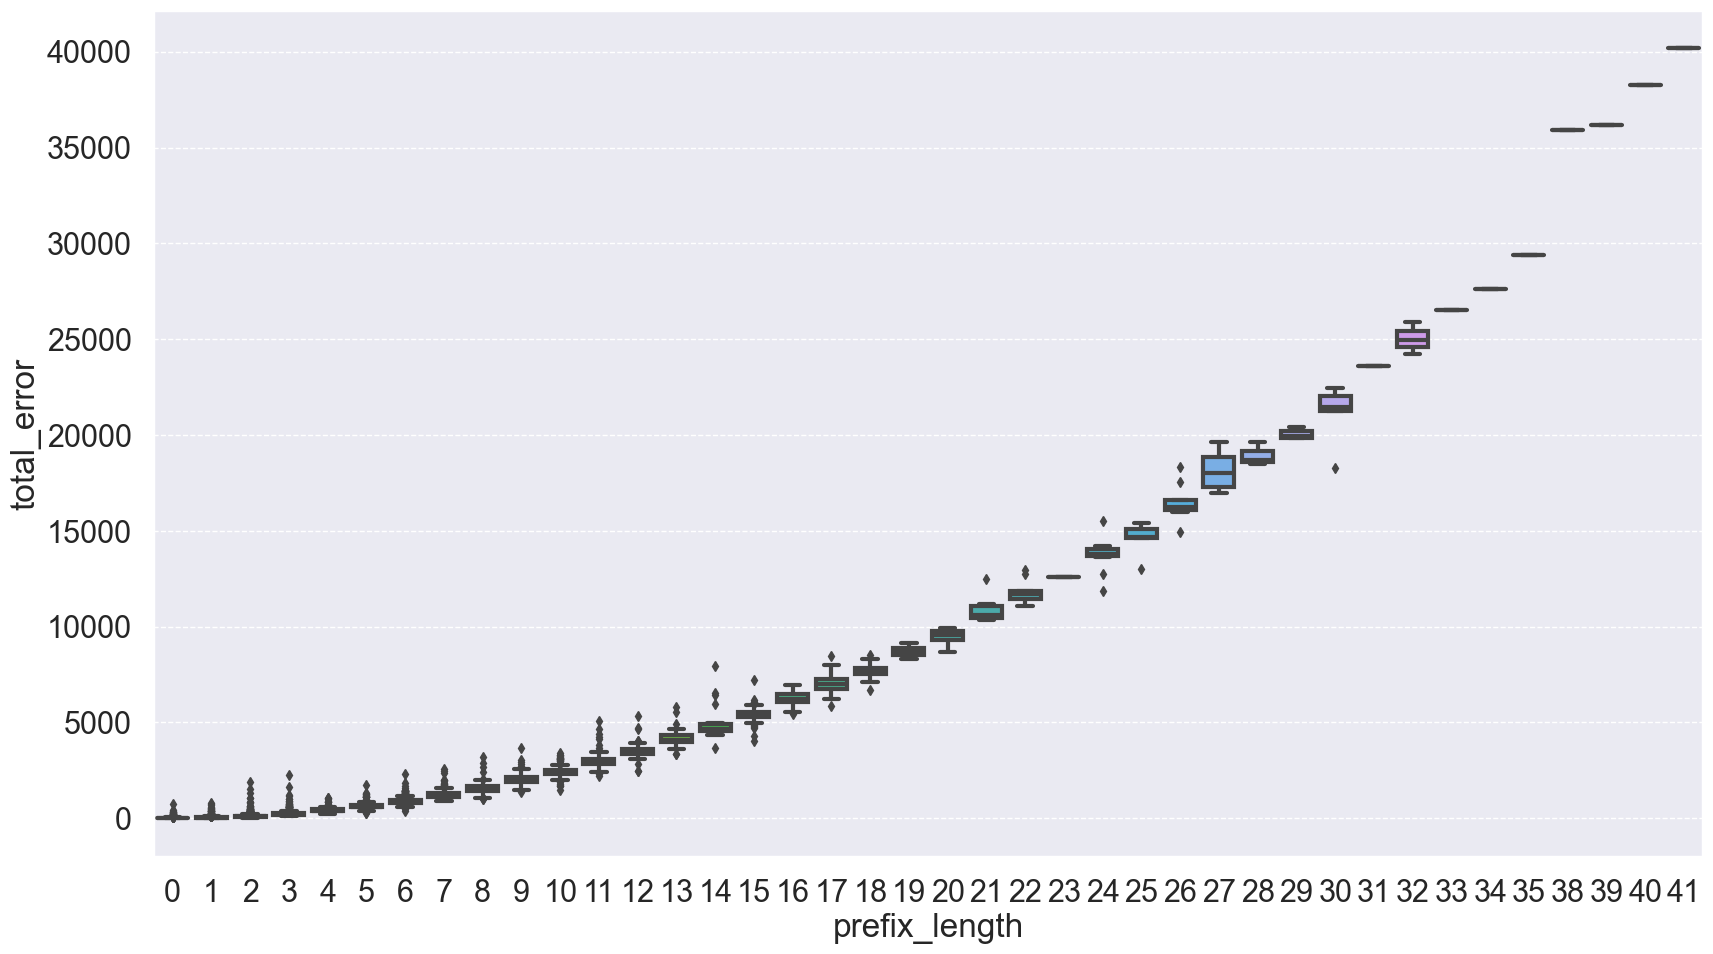

In [25]:
sns.boxplot(data=error_df,x='prefix_length',y='total_error')

In [26]:
error_df.columns

Index(['v_sequence_start', 'v_sequence_end', 'd_sequence_start',
       'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'prefix',
       'prefix_length', 'total_error'],
      dtype='object')

In [27]:
error_df[error_df.prefix_length > 7]

,v_sequence_start,v_sequence_end,d_sequence_start,d_sequence_end,j_sequence_start,j_sequence_end,prefix,prefix_length,total_error
7,58,59,58,57,58,58,AGTCGNCNGGGNGCAAANGNTANACTGGG,29,20186
8,56,56,56,57,54,56,NGAANANCTGAACNCCAAAATAAGGTTN,28,18709
31,30,30,29,29,32,30,NNNAGANGCGCCATN,15,5406
43,20,20,19,19,19,20,TGAGNCCTTN,10,2283
66,16,18,19,22,17,16,CAACGATA,8,1970
...,...,...,...,...,...,...,...,...,...
5950,19,18,18,16,15,18,TAACNGNNA,9,1814
5963,22,22,20,24,22,22,AGNTNCAAANT,11,2912
5975,22,22,22,24,22,22,NNCGNATNTNN,11,2996
5986,22,22,24,24,22,22,GNAANTGNTAN,11,3088


In [28]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

dna_base_map = {base:num for num,base in enumerate(DNA_BASES + [''])}
encoded = []
for seq in prefixes:
    counter = {base:0 for base in dna_base_map}
    for base in seq:
        counter[base] += 1
    encoded.append(np.array(list(counter.values())))
encoded = np.vstack(encoded)

# Reshape the encoded array back to the original shape

# Apply PCA for dimensionality reduction
pca = TSNE(n_components=2)
encoded_pca = pca.fit_transform(encoded)

<Axes: >

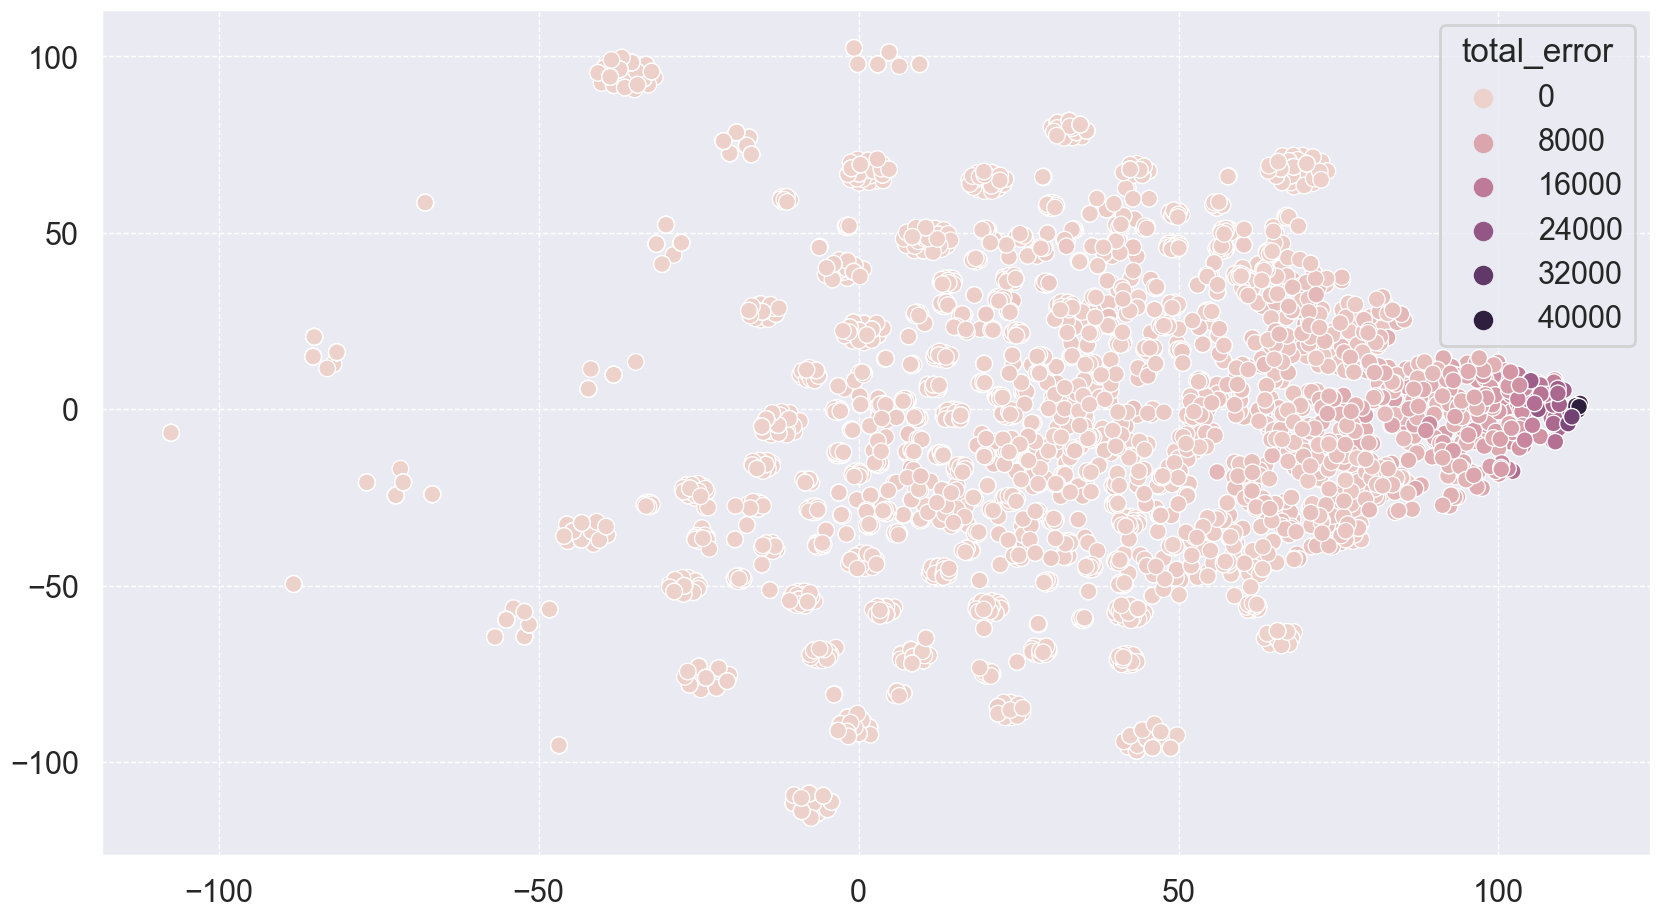

In [30]:
sns.scatterplot(x=encoded_pca[:, 0], y=encoded_pca[:, 1], hue=error_df['total_error'])

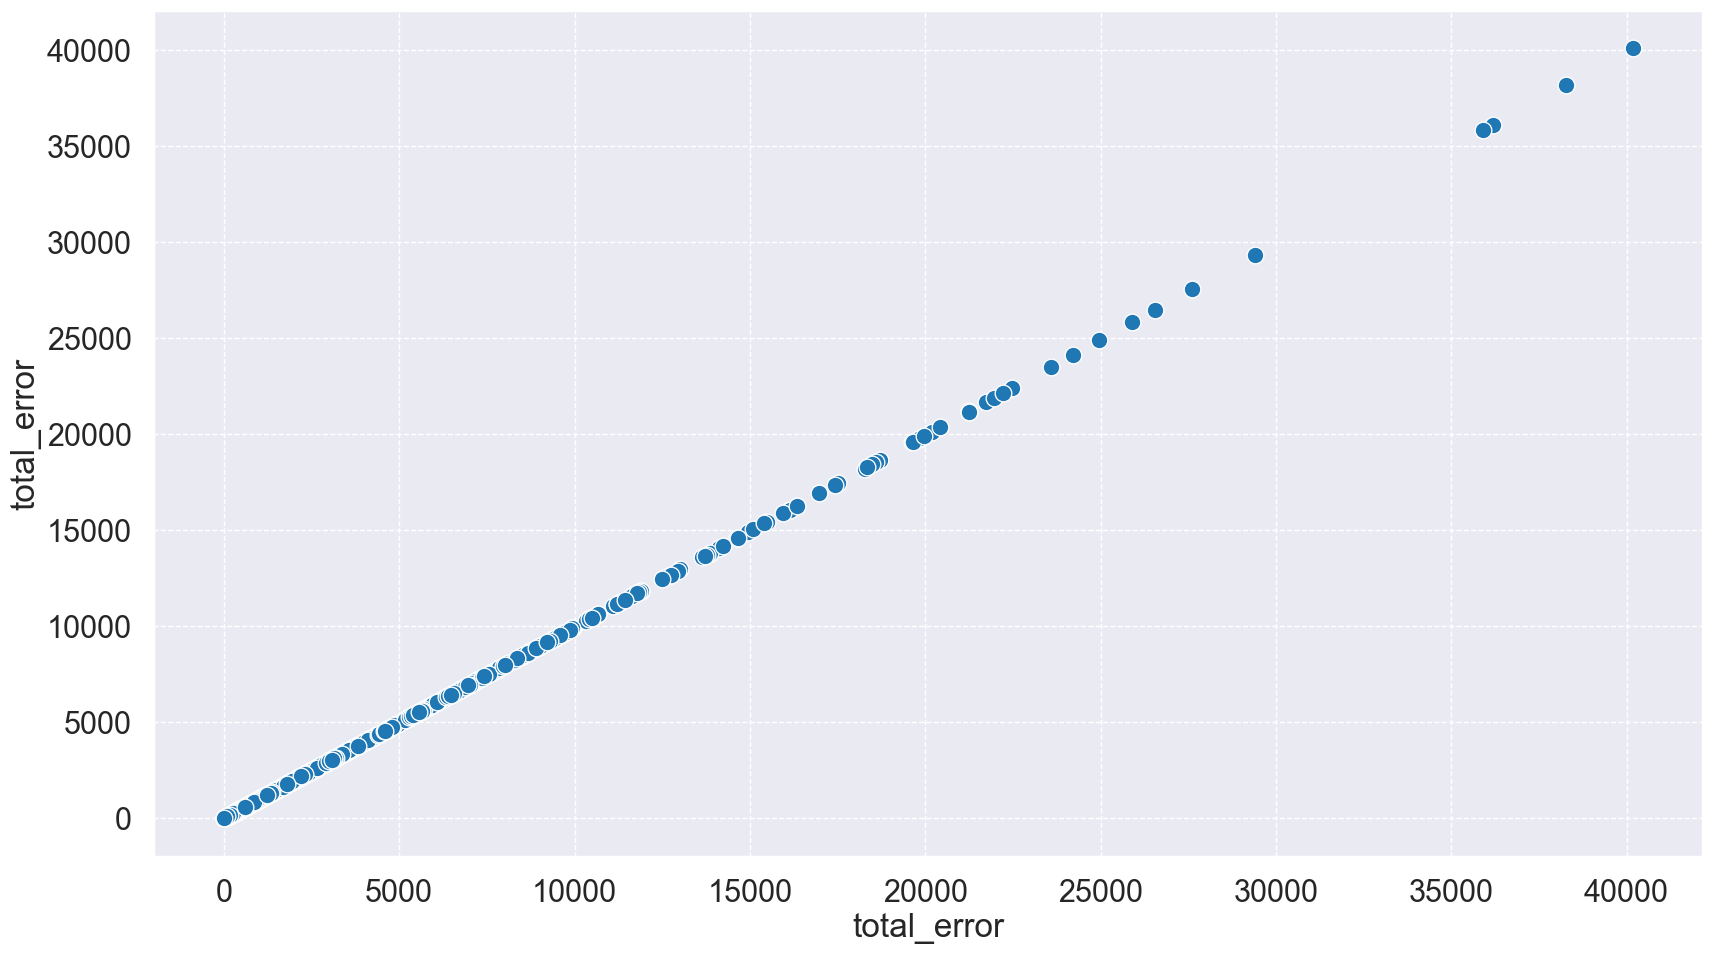

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X = encoded
y = error_df['total_error']

reg = DecisionTreeRegressor().fit(X, y)

# plot error
error = y-reg.predict(X)
sns.scatterplot(x=y,y=error)

# 10 most important features
most_important = np.argsort(np.abs(reg.feature_importances_))[-10:]



In [41]:
reverse_map = {v:k for k,v in dna_base_map.items()}
most_important = [reverse_map[i] for i in most_important]

In [42]:
most_important

['_', '', 'A', 'N', 'C', 'T', 'G']

In [43]:
error_df_s = error_df.sort_values(by='total_error',ascending=False).iloc[:100,:]

In [44]:
import os
import tempfile
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import ClustalOmegaCommandline

def align_sequences_clustalo(
    sequences,
    clustalo_path=r"C:\Users\YourName\Desktop\clustalo.exe"
) -> MultipleSeqAlignment:
    """
    Align a list of DNA sequences using Clustal Omega, returning a Biopython
    MultipleSeqAlignment object. Temporary files are created and removed.

    :param sequences: list of DNA strings
    :param clustalo_path: full path to Clustal Omega executable
    :return: a Biopython MultipleSeqAlignment of the aligned sequences
    """

    # 1. Convert the input Python list of strings into Biopython SeqRecords
    seq_records = []
    for i, dna in enumerate(sequences):
        seq_records.append(SeqRecord(Seq(dna), id=f"seq{i+1}"))

    # 2. Create temporary files for input and output FASTA
    with tempfile.NamedTemporaryFile("w", delete=False, suffix=".fasta") as tmp_in:
        input_fasta = tmp_in.name
        SeqIO.write(seq_records, tmp_in, "fasta")

    with tempfile.NamedTemporaryFile("w", delete=False, suffix=".fasta") as tmp_out:
        output_fasta = tmp_out.name

    try:
        # 3. Run Clustal Omega via the Biopython command-line wrapper
        clustalo_cline = ClustalOmegaCommandline(
            cmd=clustalo_path,        # Path to the Clustal Omega executable
            infile=input_fasta,
            outfile=output_fasta,
            force=True,               # overwrite files if needed
            outfmt="fasta"            # get aligned sequences in FASTA format
        )

        stdout, stderr = clustalo_cline()

        # 4. Read the aligned file into a MultipleSeqAlignment object
        alignment = SeqIO.parse(output_fasta, "fasta")
        alignment = list(alignment)  # turn it into a list of SeqRecords
        if not alignment:
            raise ValueError("No alignment was produced or output was empty.")

        # Convert list of SeqRecords to a MultipleSeqAlignment
        alignment_msa = MultipleSeqAlignment(alignment)

    finally:
        # 5. Clean up temporary files
        if os.path.exists(input_fasta):
            os.remove(input_fasta)
        if os.path.exists(output_fasta):
            os.remove(output_fasta)

    return alignment_msa

# Example usage
dna_sequences = error_df_s['prefix'].tolist()

# Provide the path to clustalo.exe on your Desktop (adjust as needed)
clustal_exe_path = r"C:\Users\tomas\Downloads\clustal-omega-1.2.2-win64\clustalo.exe"

aligned_result = align_sequences_clustalo(
    sequences=dna_sequences,
    clustalo_path=clustal_exe_path
)



C:\Users\tomas\Desktop\AlignAIR\AlignAIR_ENV\lib\site-packages\Bio\Application\__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [45]:
dna_base_map

{'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4, '_': 5, '': 6}

In [46]:
# plot the resulting as a heatmap
import seaborn as sns

# Convert the Biopython MultipleSeqAlignment to a pandas DataFrame
aligned_df = pd.DataFrame(
    data=[list(rec) for rec in aligned_result],
    index=[rec.id for rec in aligned_result]
)

# # replace '-' with '_'
# aligned_df = aligned_df.replace('-', '_')
# # convert the DNA bases to integers
# aligned_df = aligned_df.applymap(lambda x: dna_base_map[x])
#
# # Plot the heatmap
# plt.figure(figsize=(10, 10))
# sns.heatmap(aligned_df, cmap="viridis", cbar=False)
# plt.xlabel("Position")
# plt.ylabel("Sequence")
# plt.title("Clustal Omega Alignment of DNA Sequences")


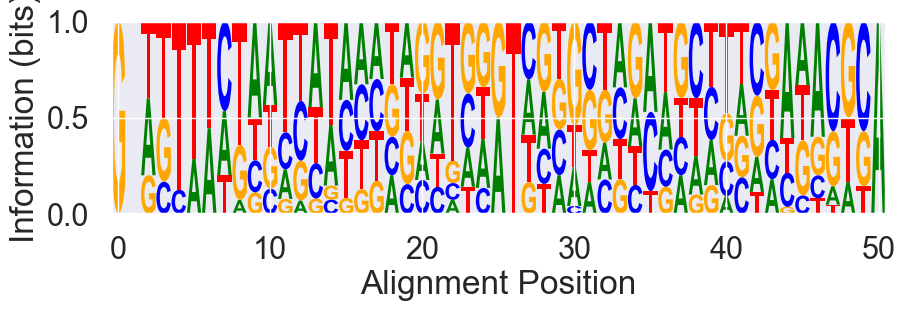

In [47]:
import pandas as pd
import logomaker
import matplotlib.pyplot as plt

def create_sequence_logo(aligned_df):
    """
    Create and display a sequence logo from the aligned DataFrame,
    removing columns that are all gaps, to avoid dividing by zero.
    """
    # 1. Make a position-frequency matrix (PFM) counting each base per column
    bases = ['A', 'C', 'G', 'T']
    pfm = pd.DataFrame(0, index=bases, columns=aligned_df.columns)

    for col in aligned_df.columns:
        # Count occurrences of each character in that column
        col_counts = aligned_df[col].value_counts()
        for base, count in col_counts.items():
            if base in bases:  # ignore gaps
                pfm.loc[base, col] = count

    # 2. Remove columns that have zero total counts (i.e., all gaps)
    pfm = pfm.loc[:, pfm.sum(axis=0) > 0]

    # 3. Convert to position-probability matrix (PPM)
    ppm = pfm.div(pfm.sum(axis=0), axis=1)

    # 4. Create a Logo from the PPM
    #    Note: each column in ppm is now guaranteed to sum to 1 and no columns are all zeros
    logo = logomaker.Logo(ppm.T,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial',
                          color_scheme='classic')

    # 5. Customize and show
    logo.ax.set_xlabel("Alignment Position")
    logo.ax.set_ylabel("Information (bits)")
    plt.show()


create_sequence_logo(aligned_df)